<a href="https://colab.research.google.com/github/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/JT_H4_En.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%matplotlib inline

In [18]:
!pip install onedrivedownloader
!pip install umap-learn
import umap.umap_ as umap

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
%%html
<style>
table td, table th, table tr {text-align:left !important;}
</style>

In [21]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, Isomap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import umap.umap_ as umap
from sklearn.metrics import accuracy_score
from itertools import permutations
import copy
import pickle
import time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
plt.rcParams['figure.figsize'] = (15, 10)

# This command determines the truth value of the interactive state of Problem 2
INTERACTIVE_MODE = True

In [22]:
from onedrivedownloader import download

link2data = 'https://unioulu-my.sharepoint.com/:u:/g/personal/jukmaatt_univ_yo_oulu_fi/EVQKkc2thRdAptI6z4eitF4BCQsEPrv6ocioVkoyeQFf3A?e=qBQ6ry'

if not os.path.exists('./data'):
    print('Downloading data')
    download(link2data, filename='./files.zip', unzip=True, unzip_path='./')

100%|██████████| 4.20M/4.20M [00:01<00:00, 2.77MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 18/18 [00:00<00:00, 323.59it/s]


# <center>521160P Introduction to artificial intelligence<br><br>Exercise #4<br><br>Unsupervised learning<br></center>

In this exercise, two-dimensional data are clustered and the number of features of high-dimensional data is dropped. **Look return deadlines from moodle** (Return instructions for this exercise are sligthly different from previous ones). It is possible to get 4 points from this exercise (2.0p + 2.0p).

If you have any questions related to exercises or you face any problems during this exercise please use moodle forum for **programming exercise 4**.

**First fill in your group information (name and student number)**

# Group member information :

* **Member 1 :** `First_name Surname 1234567 `
* **Member 2 :** `Maija Meikäläinen 2345678 `
* **Member 3 :** `... `

# Task 1. Clustering of two-dimensional data

In this task, five different two-dimensional data are clustered using three different clustering methods, K-means, DBSCAN, and agglomerative hierarchical clustering, and an evaluation of how well the algorithms perform clustering. Table 1 shows the main characteristics of the data. Place samples of the data in the graphs and illustrate their real clusters in different colors.

<br>
<div style="width:image width px; font-size:80%; text-align:left;">
    <span>Table 1. Key features of two-dimensional data</span>

| Name of the data   | Description | Ammount of clusters | Ammount of samples |
| --- | --- | --- | --- |
| **Groups** | Three clusters of different shapes, with sample densities within the clusters varying slightly. | 3 | 400 |
| **Concentrations** | Two clusters following different normal distributions. The cluster samples are partially overlapping.  | 2 | 4096 |
| **Target** |Four of the clusters are clearly distinct from the other clusters. Of the two remaining clusters, one is within the other. | 6 | 770 |
| **Diamonds** | Two adjacent diamond-shaped clusters with a constant sample density within the clusters.  | 2 | 800 |
| **Levels** | The density of the samples in the clusters varies considerably within them and the boundary between the clusters is almost imperceptible.  | 2 | 1070 |
</div>
<br>

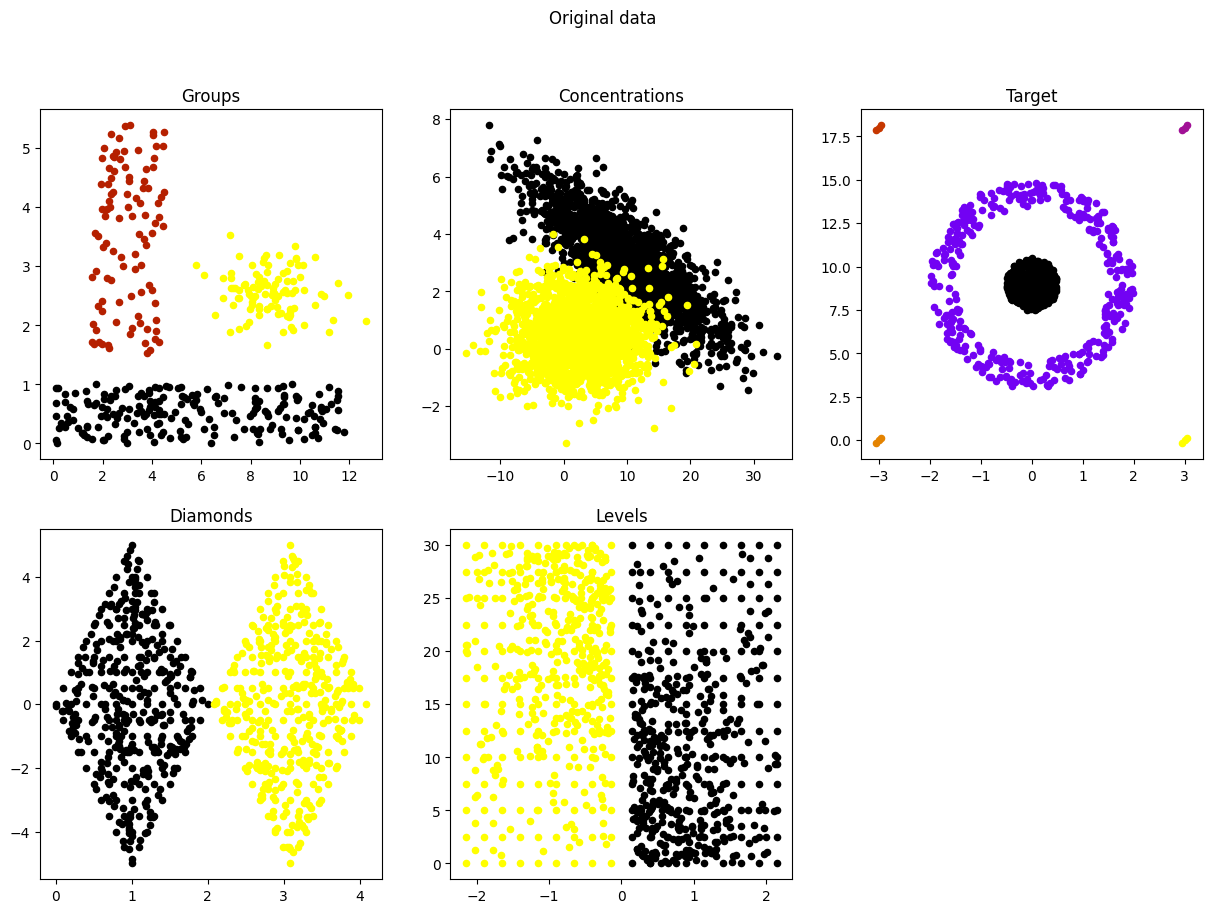

In [23]:
# Loading five different two-dimensional data
data_groups = np.loadtxt('data/ryhmat.txt', delimiter=',', usecols=[1,2])
classes_groups = np.loadtxt('data/ryhmat.txt', delimiter=',', usecols=[0])
data_concentrations = np.loadtxt('data/tihentymat.txt', delimiter=',', usecols=[1,2])
classes_concentrations = np.loadtxt('data/tihentymat.txt', delimiter=',', usecols=[0])
data_target = np.loadtxt('data/maalitaulu.txt', delimiter=',', usecols=[1,2])
classes_target = np.loadtxt('data/maalitaulu.txt', delimiter=',', usecols=[0])
data_diamonds = np.loadtxt('data/timantit.txt', delimiter=',', usecols=[1,2])
classes_diamonds = np.loadtxt('data/timantit.txt', delimiter=',', usecols=[0])
data_levels = np.loadtxt('data/tasot.txt', delimiter=',', usecols=[1,2])
classes_levels = np.loadtxt('data/tasot.txt', delimiter=',', usecols=[0])

# Save original data and classes in lists
data = np.array([data_groups, data_concentrations, data_target, data_diamonds, data_levels], dtype=object)
classes = np.array([classes_groups, classes_concentrations, classes_target, classes_diamonds, classes_levels], dtype=object)
headers = np.array(['Groups','Concentrations','Target','Diamonds','Levels'])

# Place data samples in two-dimensional graphs
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('Original data')
for i in range(data.shape[0]):
    ax = axes[i//3,i%3]
    for j in range(classes[i].shape[0]):
        _ , class_counts = np.unique(classes[i], return_counts=True)
        ax.scatter(data[i][j, 0], data[i][j, 1], c=[cm.gnuplot(classes[i][j]/(len(class_counts)-1))], s=20, marker='o')
    ax.set_title(headers[i])

It can be seen from the graphs that the value ranges of the x-axes and y-axes of the data differ greatly. Data normalization is an important pre-processing method before using clustering algorithms that utilize distance and density information. Normalize the data so that both variables scale to [0.1]. This is calculated for an individual variable by Formula 1. The value of the variable $x_i$ in the sample is subtracted from the smallest value of the variable, after which the difference obtained is divided by the entire range of the variable.

<br><br>
\begin{equation}
x_{i,\: normalized} = \frac{x_i - min(x)}{max(x) - min(x)} \tag{1}
\end{equation}
<br><br>

Place the normalized data samples in the graphs. Now the graphs have not illustrated the actual clusters of samples with colors. As such, clustering algorithms see the data before performing clustering.

Implement a function to perform data normalization that scales the data variables to [0,1] according to formula 1. Note that when data is processed as a numpy list, the conversion can be easily calculated in matrix format. For example, if you want to subtract the averages of the variables from the data *$A=\text{np.array([[1,2,1], [2,3,2], [3,4,3]])}$* $B=\text{np.mean} (A,\text{axis}=0)$ then *$AB =\text{array([[- 1, -1, -1], [0, 0.0], [1,1,1]])}$*

Check from the plotted graphs that the data normalizations were successful.

TypeError: 'NoneType' object is not subscriptable

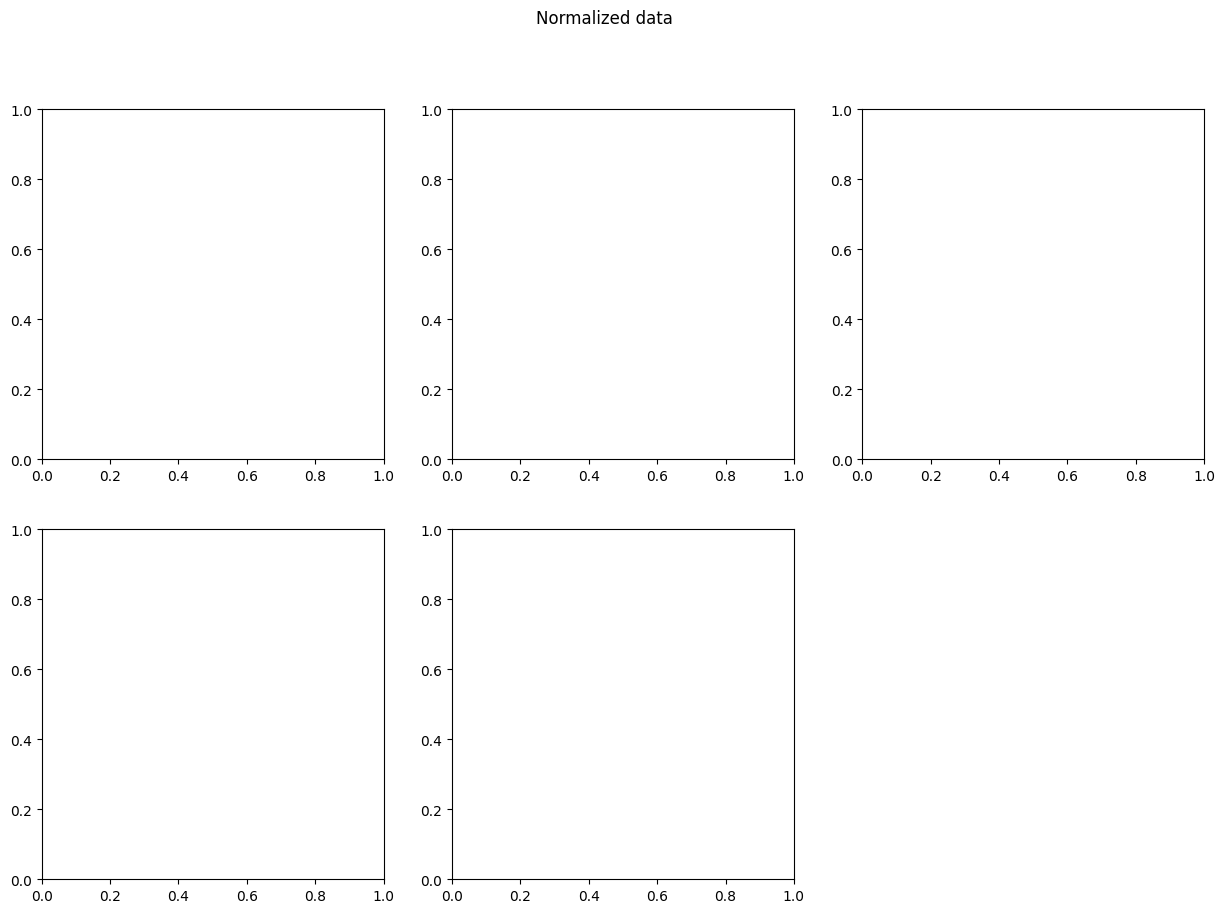

In [24]:
def normalize_variables(data):
    """
    This function normalizes the data variables to [0,1]
    """
    # Determine the maximum and minimum values of the variables and store them in the lists
    data_min, data_max = np.min(data, axis=0), np.max(data, axis=0)
    #-------YOUR CODE HERE--------
    # Perform data normalization according to formula 1

    # Function returns normalized data

    #--------------------------------

# Normalize data
data_groups_normalized = normalize_variables(data_groups)
data_concentrations_normalized = normalize_variables(data_concentrations)
data_target_normalized = normalize_variables(data_target)
data_diamonds_normalized = normalize_variables(data_diamonds)
data_levels_normalized = normalize_variables(data_levels)

# The normalized data is stored in the list
data_normalized = np.array([data_groups_normalized, data_concentrations_normalized, data_target_normalized, data_diamonds_normalized, data_levels_normalized], dtype=object)

# Place normalized data samples in two-dimensional graphs to ensure that data variables scale to [0.1]
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('Normalized data')
for i in range(data_normalized.shape[0]):
    ax = axes[i//3,i%3]
    for j in range(classes[i].shape[0]):
        ax.scatter(data_normalized[i][j, 0], data_normalized[i][j, 1], c='k', s=20, marker='o')
    ax.set_title(headers[i])

Next, clustering is performed with three different clustering algorithms, K-means, DBSCAN, and agglomerative hierarchical clustering. Evaluate the success of clusters using classification accuracy, which is printed below the graphs. Note that clustering algorithms do not take advantage of class data, but the categories of clustered samples are compared to their actual classes only afterwards to assess the success of clustering.

## K-means

Use the scikit-learn library function [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to perform clustering. The K-means algorithm needs information about the number of clusters in advance. In addition, instead of randomly formatted cluster centers, the k-means++ strategy is used, in which the cluster centers are initialized as far apart as possible.

In [ ]:
def run_k_means_clustering(data, n_clusters):
    """
    In this function, the data is clustered by the K-means algorithm and finally the clustered classes of the samples are returned.
    """
    model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=20, random_state=0).fit(data)
    classes_kmeans = model.labels_
    return classes_kmeans

def find_best_colours_for_clusters(classes, clustered_classes):
    """
    In this function, colors are selected for clustered samples so that they resemble as closely as possible the colors of the original clusters.
    """
    categories = list(set(clustered_classes))
    _permutations = list(permutations(categories, len(categories)))
    hits = []
    classes_changed = []
    for i in range(len(_permutations)):
        classes_tmp = copy.deepcopy(clustered_classes)
        for j in range(len(categories)):
            classes_tmp = [str(_permutations[i][j]) if x==categories[j] else x for x in classes_tmp]
        classes_tmp = [int(i) for i in classes_tmp]
        counter = 0
        for k in range(len(classes_tmp)):
            if classes_tmp[k] == classes[k]:
                counter += 1
        hits.append(counter)
        classes_changed.append(classes_tmp)
    index = hits.index(max(hits))
    return np.array(classes_changed[index])

n_clusters_list = [3,2,6,2,2]

# Place clustered data samples in two-dimensional images
# It will take a while to run this step
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('The results produced by the K-means algorithm ')
for i in range(data_normalized.shape[0]):
    ax = axes[i//3,i%3]
    classes_kmeans = run_k_means_clustering(data_normalized[i], n_clusters_list[i])
    classes_kmeans = find_best_colours_for_clusters(classes[i], classes_kmeans)
    for j in range(classes_kmeans.shape[0]):
        ax.scatter(data_normalized[i][j, 0], data_normalized[i][j, 1], c=[cm.gnuplot(classes_kmeans[j]/(n_clusters_list[i]-1))], s=20, marker='o')
    ax.set_title(headers[i])
    ax.set_xlabel('Classification accuracy  = {} %'.format(round(100*accuracy_score(classes_kmeans, classes[i]),3)))

## DBSCAN

Use the scikit-learn library function [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to perform DBSCAN clustering. The DBSCAN algorithm takes information about the minimum distance at which a sample still belongs to a cluster, as well as the minimum number of samples that the cluster to be formed must contain at least.

In [ ]:
def run_dbscan_clustering(data, min_distance, min_samples):
    """
    In this function, the data is clustered using the DBSCAN algorithm and finally the classes of the samples are returned.
    """
    model = DBSCAN(eps=min_distance, min_samples=min_samples).fit(data)
    classes_dbscan = model.labels_
    classes_dbscan = [len(set(classes_dbscan)) if x==-1 else x for x in classes_dbscan]
    return classes_dbscan

min_distances = [0.1025,0.021,0.05,0.065,0.06]
min_samples_list = [2,22,2,13,2]

# Place clustered data samples on two-dimensional graphs
# It will take a while to run this step
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('The results produced by the DBSCAN algorithm ')
for i in range(data_normalized.shape[0]):
    ax = axes[i//3,i%3]
    classes_dbscan = run_dbscan_clustering(data_normalized[i], min_distances[i], min_samples_list[i])
    classes_dbscan = find_best_colours_for_clusters(classes[i], classes_dbscan)
    for j in range(classes_dbscan.shape[0]):
        ax.scatter(data_normalized[i][j, 0], data_normalized[i][j, 1], c=[cm.gnuplot(classes_dbscan[j]/(n_clusters_list[i]-1))], s=20, marker='o')
    ax.set_title(headers[i])
    ax.set_xlabel('Classification accuracy = {} %'.format(round(100*accuracy_score(classes_dbscan, classes[i]),3)))

## Agglomerative hierarchical clustering

Use the scikit-learn library function [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) for performing the clustering. By setting the linking strategy to ‘Ward’, the samples are combined to minimize the variance between them. The 'single' linking strategy combines the samples to minimize the shortest distances between sample sets and the 'average' linking strategy combines the samples to minimize the averaged distances between sample sets. Agglomerative hierarchical clustering also requires prior knowledge of the number of clusters.

In [ ]:
def run_agglomerative_hierarchical_clustering(data, n_clusters, linking_strategy):
    """
    In this function data is clustered with agglomerative clustering and at the end of function classes of samples are returned
    """
    model = AgglomerativeClustering(linkage=linking_strategy, n_clusters=n_clusters).fit(data)
    classes_hierarchical = model.labels_
    return classes_hierarchical

linking_strategy = ['single','ward','single','average','single']

# Place clustered data samples on two-dimensional graphs
# It will take a while to run this step
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('Agglomerative hierarchical clustering algorithm results')
for i in range(data_normalized.shape[0]):
    ax = axes[i//3,i%3]
    classes_hierarchical = run_agglomerative_hierarchical_clustering(data_normalized[i], n_clusters_list[i], linking_strategy[i])
    classes_hierarchical = find_best_colours_for_clusters(classes[i], classes_hierarchical)
    for j in range(classes_hierarchical.shape[0]):
        ax.scatter(data_normalized[i][j, 0], data_normalized[i][j, 1], c=[cm.gnuplot(classes_hierarchical[j]/(n_clusters_list[i]-1))], s=20, marker='o')
    ax.set_title(headers[i])
    ax.set_xlabel('Classification accuracy = {} %'.format(round(100*accuracy_score(classes_hierarchical,classes[i]),3)))

**Why can't the K-means algorithm cluster data Groups correctly and the DBSCAN algorithm fails to cluster data Concentrations?**

`Your answer here`

# Task 2. Reducing dimensionality

The second task creates two-dimensional visualizations for three different data using algorithms [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html), [LLE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html), [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and [UMAP](https://umap-learn.readthedocs.io/en/latest/). In addition, the number of features of the high-dimensional data is dropped and its effect on the classification accuracy and teaching time of the classifier being taught is evaluated.

The following data is used in the task:

### Wines data

Wines data consists of different characteristics of three Italian wine varieties. The data contain a total of 178 samples. Thirteen characteristics of the wine have been used as traits, such as alcohol content, amount of malic acid, amount of ash, amount of magnesium, intensity of color and hue of the wine.

### Fashion MNIST

Fashion MNIST data, like MNIST data, contains 70,000 samples from ten different categories. The samples are 28x28 pixel grayscale images of garments such as t-shirts, pants, bags, sandals, sweaters and jackets. The pictures were taken against a black background. For this task, a set of 700 samples has been selected from the original fashion MNIST data to reduce the computation time of the algorithms. Figure 1 shows sample images of all categories of fashion MNIST data.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/muotimnist.png?raw=1' width='950' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 1. Sample images of all categories of fashion MNIST data. </span>
</div>
<br>

### Branch data

Branch data includes the most common branch types for sawn timber defects. The branch is a hard wood material, the autumn direction of which is perpendicular to the autumn direction of the tree trunk. The original graft data contains RGB images of different sizes, but to perform dimensional reductions, the images are scaled to 40x40 pixels. The types of branches are divided into categories based on the quality of the branch and the direction of sawing. Figure 2 shows example images of all classes of branch data.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/oksa.png?raw=1' width='600' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 2. Sample images of all classes of branch data.</span>
</div>
<br>

First load the data

In [ ]:
# Load data
with open("data/viinidata.pkl", "rb") as f1:
    data_f1 = pickle.load(f1)
data_wine, classes_wine = np.array(data_f1[0]), np.array(data_f1[1])
class_names_wine = ['wine 1', 'wine 2', 'wine 3']

with open("data/muoti_mnist_data.pkl", "rb") as f2:
    data_f2 = pickle.load(f2)
data_fashion, classes_fashion = np.array(data_f2[0]), np.array(data_f2[1])
class_names_fashion = ['t-shirts','trousers','sweaters','dresses','coats','sandals','shirts','sneakers','bags','boots']

with open("data/oksadata.pkl", "rb") as f3:
    data_f3 = pickle.load(f3)
data_branch, classes_branch = np.array(data_f3[0]), np.array(data_f3[1])
class_names_branch = ['Fresh branch','Dry branch','Edge branch','leaf branch','Horn branch','a branch surrounded by bark','rotten branch']

## Data visualization

Transformations are performed on the data by different dimensional reduction methods. The success of the transformation is evaluated by teaching the classifier of the k-nearest neighbor in the _transformed dimension and calculating the classification accuracy of the teaching data. Note that dimensional reduction methods do not take advantage of class data, but the predicted classes of the _transformed samples are compared with their actual classes only after the calculation of the classification accuracy.

Teach the k-nearest neighbor classifier in the _transformed dimension, predict classes for the _transformed data, and calculate the classification accuracy.

In [ ]:
def transform_data(data, parameters=[]):
    """
    This function converts data into two dimensions using different dimensional subtraction methods.
    """
    data_pca = PCA(n_components=2, random_state=0).fit_transform(data)
    data_mds = MDS(n_jobs=-1, random_state=0).fit_transform(data)
    data_lle = LocallyLinearEmbedding(eigen_solver='arpack', method='modified',n_neighbors=parameters[0], n_jobs=-1, random_state=0).fit_transform(data)
    data_isomap = Isomap(n_neighbors=parameters[1]).fit_transform(data)
    data_tsne = TSNE(n_components=2, perplexity=parameters[2], metric='sqeuclidean', random_state=0).fit_transform(data)
    data_umap = umap.UMAP(n_neighbors=parameters[3], min_dist=parameters[4], metric='correlation', random_state=0).fit_transform(data)
    data_transformed = np.array([data_pca, data_mds, data_lle, data_isomap, data_tsne, data_umap])
    return data_transformed

def calc_accuracy_transformed_dimension(data_transformed, classes, k):
    """
    This function calculates the classification accuracy of the training data for the data converted to the classifier of the k-nearest neighbor.
    """
    # Specify the classifier
    classifier_knn = KNeighborsClassifier(n_neighbors=k)
    #-------YOUR CODE HERE--------
    # Teach the k-nearest neighbor classifier with the transformed data (Hint: .fit (teaching data, teaching data classes))

    # Classify the transformed data (Hint: .predict(teaching data))

    # Calculate the classification accuracy of the teaching data for the classifier (Hint: accuracy_score (teaching data classes, predicted classes))

    # Function returns classification accuracy

    #--------------------------------

Visualization of wine data by different dimensional reduction methods is performed.

*(If the python library umap-learn gives an error message and you are using a 32-bit system, you can fix the error by going to the umap folder (eg C:\Users\Tuomas\AppData\Local\Programs\Python\Python37\Lib\site-packages\umap) and replacing 'parallel = True' with 'parallel = False' in the folder's python files. Removing parallel computing from the UMAP algorithm will slightly reduce its performance, so only perform this operation if you have problems with the umap-learn library.)*

In [ ]:
# Perform dimensional reduction by different methods for wine data
algorithms = ['PCA','MDS','LLE','Isomap','t-SNE','UMAP']
colours_wine = np.unique(classes_wine, return_inverse=True)[1]
data_wine_transformed = transform_data(data_wine, parameters=[11,13,27,24,0.024])
for i in range(data_wine_transformed.shape[0]):
    fig, ax = plt.subplots(figsize=(14,10))
    plt.scatter(data_wine_transformed[i][:,0],data_wine_transformed[i][:,1], s=30, c=colours_wine,  cmap='rainbow', edgecolor='k')
    definitions = [plt.plot([],[], marker='o',markeredgecolor='k', color=cm.rainbow(int(j)/(len(class_names_wine)-1)), linestyle='None', label=class_names_wine[j])[0]  for j in range(len(class_names_wine))]
    plt.legend(handles=definitions, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Two-dimensional visualization of wine data with {} algorithm'.format(algorithms[i]), fontsize=18)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('Classification accuracy in two-dimensional feature space: {} %'.format(round(calc_accuracy_transformed_dimension(data_wine_transformed[i], classes_wine, 15)*100,3)))

**Which three dimensional reduction methods best visualize wine data based on two-dimensional graphs and classification accuracies?**

`Your answer here`

Next, the visualization of the fashion MNIST data by different dimensional reduction methods is performed.

Run through the code blocks one at a time by pressing the 'Run' button to see the interactive visualizations. By hovering the cursor over a data point in the graph, you can see what kind of samples place in different parts of the feature space. After reviewing, closing the interactive graph is handled by the $\text{plt.close ('all')}$ command in the next block of code.

In [ ]:
# To perform interactive visualizations, it is necessary to run this block of code
if INTERACTIVE_MODE:
    %matplotlib widget

In [ ]:
def hover(event):
    """
    This function allows the image to be played back with the cursor over the data point.
    """
    if data_points.contains(event)[0]:
        indices = data_points.contains(event)[1]['ind']
        index = indices[0]
        width, korkeus = fig.get_size_inches()*fig.dpi
        widths = (event.x > width/2.)*-1 + (event.x <= width/2.)
        heights = (event.y > korkeus/2.)*-1 + (event.y <= korkeus/2.)
        observation_img_box.xybox = (img_box_size[0]*widths, img_box_size[1]*heights)
        observation_img_box.set_visible(True)
        observation_img_box.xy =(x_coordinate[index], y_coordinate[index])
        formated_img.set_data(images_tmp[index,:,:])
    else:
        observation_img_box.set_visible(False)
    fig.canvas.draw_idle()

def interactive_visualization(transformed_data, classes, images, colours, class_names, algorithm_name, data_name):
    global data_points, fig, ax, observation_img_box, img_box_size, x_coordinate, y_coordinate, formated_img, images_tmp
    # Place data points on the graph
    images_tmp = images
    fig, ax = plt.subplots(figsize=(14,10))
    x_coordinate = transformed_data[:,0]
    y_coordinate = transformed_data[:,1]
    data_points = plt.scatter(x_coordinate,y_coordinate, s=30, c=colours,  cmap='jet', edgecolor='k')
    definitions = [plt.plot([],[], marker='o',markeredgecolor='k', color=cm.jet(int(i)/(len(class_names)-1)), linestyle='None', label=class_names[i])[0]  for i in range(len(class_names))]
    plt.legend(handles=definitions, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('{} data two-dimensional visualization with {} algorithm'.format(data_name, algorithm_name), fontsize=18)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('Classification accuracy in 2D feature space: {} %'.format(round(calc_accuracy_transformed_dimension(transformed_data, classes, 15)*100,3)))

    # Create observation image
    formated_img = OffsetImage(images[1,:,:], zoom=2, cmap=plt.cm.gray_r)
    img_box_size = (40, 40)
    observation_img_box = AnnotationBbox(formated_img, (0,0), xybox=img_box_size, xycoords='data', boxcoords='offset points',  pad=0.3,  arrowprops=dict(arrowstyle='->'))
    ax.add_artist(observation_img_box)
    observation_img_box.set_visible(False)

    # Performs image playback with the mouse over the data point
    fig.canvas.mpl_connect('motion_notify_event', hover)

In [ ]:
# Perform dimensional reduction by various methods on fashion MNIST data
# Note. if running this item gives a RuntimeWarning error message, run it again
# Before running the next block of code, wait for this intermediate step to complete (it will take a while).

data_fashion_transformed = transform_data(data_fashion, parameters=[10,10,11,13,0.013])
colours_fashion = np.unique(classes_fashion, return_inverse=True)[1]
images_fashion = np.reshape(data_fashion, (700,28,28))

In [ ]:
# Fashion Interactive two-dimensional visualization of MNIST data by PCA algorithm
interactive_visualization(data_fashion_transformed[0], classes_fashion, images_fashion, colours_fashion, class_names_fashion, 'PCA-', 'Muoti MNIST-')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Fashion Two-dimensional interactive visualization of MNIST data using the MDS algorithm
interactive_visualization(data_fashion_transformed[1], classes_fashion, images_fashion, colours_fashion, class_names_fashion, 'MDS-', 'Muoti MNIST-')
plt.show();

In [ ]:
# Close the previous interactive two-dimensional visualization
plt.close('all')

# Fashion MNIST two-dimensional visualization with LLE algorithm
interactive_visualization(data_fashion_transformed[2], classes_fashion, images_fashion, colours_fashion, class_names_fashion, 'LLE-', 'Muoti MNIST-')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Fashion MNIST two-dimensional visualization with Isomap algorithm
interactive_visualization(data_fashion_transformed[3], classes_fashion, images_fashion, colours_fashion, class_names_fashion, 'Isomap-', 'Muoti MNIST-')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Fashion MNIST two-dimensional visualization with t-SNE algorithm
interactive_visualization(data_fashion_transformed[4], classes_fashion, images_fashion, colours_fashion, class_names_fashion, 't-SNE-', 'Muoti MNIST-')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')
# Fashion MNIST interactive two-dimensional visualization with UMAP algorithm
interactive_visualization(data_fashion_transformed[5], classes_fashion, images_fashion, colours_fashion, class_names_fashion, 'UMAP-', 'Muoti MNIST-')
plt.show();

In [ ]:
# Close interactive two-dimensional visualization
plt.close('all')

**Which three dimensional reduction methods best visualize fashion based on two-dimensional graphs and classification accuracies of MNIST data?**

`Your answer here`

### Branch data

Visualization of branch data by different dimensional reduction methods is performed.

In [ ]:
# Perform dimensional reduction to two-dimensional representations for branch data by different methods
# Note. if running this section gives a RuntimeWarning error message, run the section again
# Before running the next block of code, wait for this intermediate step to complete (it will take a while).
data_branch_transformed = transform_data(data_branch, parameters=[13,26,24,5,0.05])
colours_branch = np.unique(classes_branch, return_inverse=True)[1].tolist()
images_branch = np.reshape(data_branch, (438,40,40,3))

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Branch data interactive two-dimensional visualization with PCA algorithm
interactive_visualization(data_branch_transformed[0], classes_branch, images_branch, colours_branch, class_names_branch, 'PCA-', 'Oksa')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Branch data interactive two-dimensional visualization with MDS algorithm
interactive_visualization(data_branch_transformed[1], classes_branch, images_branch, colours_branch, class_names_branch, 'MDS-', 'Oksa')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Branch data interactive two-dimensional visualization with LLE algorithm
interactive_visualization(data_branch_transformed[2], classes_branch, images_branch, colours_branch, class_names_branch, 'LLE-', 'Oksa')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Branch data interactive two-dimensional visualization with Isomap algorithm
interactive_visualization(data_branch_transformed[3], classes_branch, images_branch, colours_branch, class_names_branch, 'Isomap-', 'Oksa')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Branch data interactive two-dimensional visualization with t-SNE algorithm
interactive_visualization(data_branch_transformed[4], classes_branch, images_branch, colours_branch, class_names_branch, 't-SNE-', 'Oksa')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

# Branch data interactive two-dimensional visualization with UMAP algorithm
interactive_visualization(data_branch_transformed[5], classes_branch, images_branch, colours_branch, class_names_branch, 'UMAP-', 'Oksa')
plt.show();

In [ ]:
# Closes the previous interactive two-dimensional visualization
plt.close('all')

**Which three dimensional reduction methods best visualize branch data based on two-dimensional graphs and classification accuracies?**

`Your answer here`

**Why does principal component analysis not work very well in visualizations for fashion MNIST data and branch data?**

`Your answer here`

## Reducing the number of features

Another common use for dimensional reduction is the efficient compression of features to reduce the computation time required to teach the classifier. Uses principal component analysis to extract the information from the original variables of the fashion MNIST data into the principal components. This is followed by a number of features of 1-700 every ten steps.

Calculate the classification accuracy for the classifier of the k-nearest neighbor and the time taken to teach the classifier when $k$ is 5. Add the classification accuracies and calculation times to the lists. Finally, draw a graph of how the classification accuracies and the computation time required to teach the classifier depend on the number of features.

In [ ]:
%matplotlib inline
classification_accuracies = []
computing_times = []

# Perform principal component analysis for fashion MNIST data
data_fashion_pca = PCA(n_components=700, random_state=0).fit_transform(data_fashion)

# Go through the numbers of features 1-700 every ten steps, teach the classifier of the k-nearest neighbor, and calculate the classification accuracy and time spent teaching
features_number = range(1,700,10)
for i in features_number:
    # From the transformed data i the first principal component is selected
    data_fashion_transformed = data_fashion_pca[:,0:i]
    #-------YOUR CODE HERE--------
    # Get the start time t1 (Hint: time.time ())

    # Calculate the classification accuracy for the classifier with the function calc_accuracy_transformed_dimension (data_fashion_transformed, classes_fashion, 5) when k is 5.

    # After training the classifier, get time t2 (Hint: time.time ())

    # Calculate the time difference to find out the time spent processing the data

    # Add the calculated classification accuracy to the classification_accuracies list

    # Add the time difference to the computing_times list

    #--------------------------------

# Plot on the graph the effect of the number of features on the classification accuracy of the classifier
plt.figure(figsize=(15,10))
plt.plot(features_number, classification_accuracies)
plt.title('the classification accuracy of the k-nearest neighbor classifier with different numbers of features ')
plt.xlabel('Ammount of features')
plt.ylabel('Classification accuracy')

# Piirretään kuvaajaan piirteiden lukumäärän vaikutus luokittelijan opettamiseen kuluneeseen aikaan
plt.figure(figsize=(15,10))
plt.plot(features_number, computing_times)
plt.title('the time spent teaching the k-nearest neighbor classifier with different numbers of features')
plt.xlabel('Ammount of features')
plt.ylabel('Computing time')
plt.show()

# Finally, select the optimal number of features from the classification accuracy graph
max_index_knn = np.argmax(classification_accuracies)
print('With an optimal number of features ({}) classification accuracy is {} % and the time taken to teach the classifier is  {} seconds.'.format(features_number[max_index_knn], round(classification_accuracies[max_index_knn]*100,3), round(computing_times[max_index_knn],3)))

**What phenomenon describes the scenario where the classification rate of a k-nearest neighbor classifier is better when using a training set of reduced dimensions rather than the original high-diemnsional training set? How does the number of dimensions affect the the computation time?**

`Your answer here`

# Feedback

Finaly answer following questions

**How much time did you spend doing this exercise?**

`Your answer here`

**Did you encounter any problems or challenges while doing the exercise? Were the notebook sufficiently comprehensive instructions for doing the exercise?**

`Your answer here`

**Other feedback related to to this exercise?**

`Your answer here`

# Returning the exercise
1. First of all **turn off the interactive mode** in notebook's 4th code block **INTERACTIVE_MODE = False**
2. Before you return this notebook **make sure that code in notebook works properly** and returns all necessary values by choosing from menu `Kernel -> Restart & Run All`! also make sure you have answer all questions on **bold** (**NOTICE: running code blocks again takes quite long time**)
3. **Contrary to previous exercises** do not clear the printouts and variables, but press the save button after completing Step 1!
4. Rename this notebook in following format **`JT_H4_[student_number(s)].ipynb`** (e.g `JT_H4_1234567.ipynb` or if you have group `JT_H4_1234567_2345678_3456789.ipynb`)
5. Return **only** solved notebook(`file ending with .ipynb`) to moodle programming exercise 3. Everyone must return file to moodle even if you work in a group. **Don't include working directory or other files** when you return the exercise.
6. Finally go answer questions in moodle related to programming exercise 4. Everyone in your group must answer to questions.